NAME : Danny

SURNAME : D'Agostino

NUMBER : 1247958

\vspace{5mm}

\vspace{5mm}

\vspace{5mm}

\vspace{5mm}

In [2]:
%matplotlib inline
from __future__ import division
from mlxtend.evaluate import plot_decision_regions
from sklearn.datasets import fetch_mldata
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

\vspace{5mm}

Loading the dataset:

In [3]:
mnist = fetch_mldata('MNIST original')
X = mnist.data
y = mnist.target

\vspace{5mm}

Now we take only the classes from 1 to 7:

In [26]:
delval = [0,8,9]
indexremove = []
print len(y)
for i in range(len(y)):
    if y[i] in delval:
        indexremove.append(i)
y1 = np.delete(y,indexremove)
x1 = np.delete(X,indexremove,axis=0)
print np.shape(x1),np.shape(y1) 

70000
(49314, 784) (49314,)


\vspace{5mm}

We standardize the data and split it into training, test and validation set:

In [27]:
X_stan = preprocessing.scale(x1)
d = np.column_stack((X_stan, y1))
np.random.shuffle(d)
train_data = d[:24656]
val_data = d[24657:34519]
test_data = d[34519:49314]

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


\vspace{5mm}

We'll train SVM varying the parameter C

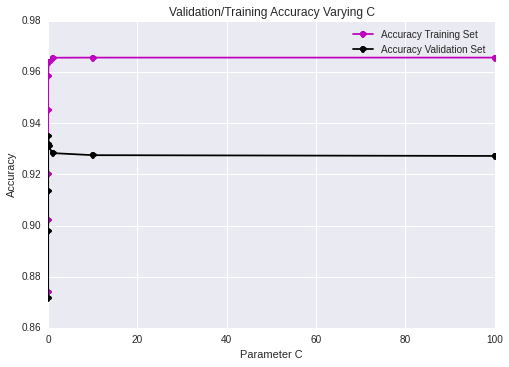

In [6]:
c = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]
X_train = train_data[:,:784]
y_train = train_data[:,784]
X_val = val_data[:,:784]
y_val = val_data[:,784]
X_test = test_data[:,:784]
y_test = test_data[:,784]
acc_val = []
acc_train = []
t = []
for value in c:
    start = timer()
    svc = LinearSVC(C = value,dual=False)
    svc.fit(X_train,y_train)
    end = timer()
    accuracy_train = svc.score(X_train,y_train)
    accuracy_val = svc.score(X_val,y_val)
    acc_val.append(accuracy_val)
    acc_train.append(accuracy_train)
    t0 = end-start
    t.append(t0)
mt = sum(t)/len(t)
plt.plot(c,acc_train,color='m', label='Accuracy Training Set',marker='o')
plt.plot(c,acc_val,color='k', label='Accuracy Validation Set',marker='o')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.title('Validation/Training Accuracy Varying C')
plt.legend(loc='upper right')
sns.set_style("darkgrid")
plt.show()

\vspace{5mm}

If we zoom the left side we can see the maximum :

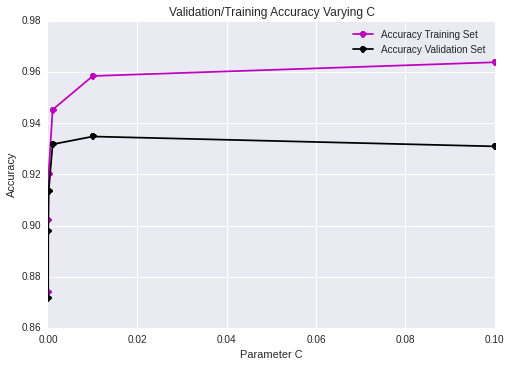

In [12]:
plt.plot(c,acc_train,color='m', label='Accuracy Training Set',marker='o')
plt.plot(c,acc_val,color='k', label='Accuracy Validation Set',marker='o')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.xlim(c[0], c[5])
plt.title('Validation/Training Accuracy Varying C')
plt.legend(loc='upper right')
sns.set_style("darkgrid")
plt.show()

\vspace{5mm}


We choose C = 0.01  where achieve the maximum accuracy on the validation set :

In [28]:
svc = LinearSVC(C = 0.01,dual=False)
svc.fit(X_train,y_train)
accuracy_test = svc.score(X_test,y_test)

In [29]:
print accuracy_test

0.965303038782


\vspace{5mm}

Now we'll training a multiclass non linear SVM :

In [4]:
delval = [5,6,7,8,9]
indexremove = []
for i in range(len(y)):
    if y[i] in delval:
        indexremove.append(i)
y1 = np.delete(y,indexremove)
x1 = np.delete(X,indexremove,axis=0)
print np.shape(x1),np.shape(y1) 

(35735, 784) (35735,)


\vspace{5mm}

Standardize :

In [ ]:
X_stan = preprocessing.scale(x1)

\vspace{5mm}

We'll splitting 50% in test and training set in a stratified way :

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_stan, y1, test_size=.5,stratify=y1)

\vspace{5mm}

Stratification it's really important because in our case we split the whole dataset in exactly two parts : one for the training set and the other for the test set. This means that we must to ensure this two sets are representative of all the data. If we don't make this our result can be depends on the particular split of our dataset.

\vspace{5mm}

And now we'll train the classifier with one-against-all, with gamma and C respectively equals to : 1 and 0.1. With the one-against-all method we consider k classifier where k is the number of classes. The j-th binary classifier separate the data from the class j from the all other classes. Thus in the training phase we have exactly k-optimizations routine. 
Also we need the decision function for understand in which class belong a generic input data x, for make this we must to find the maximum value of the argument of : $$class\left ( x \right ) = \arg\underset{1\leq j\leq k }{\max }\left \{ w^{j^{T}}\phi \left ( x \right )+ b^{j} \right \}$$

In [7]:
nsvm = SVC(C=0.1,kernel='rbf',gamma=1, cache_size = 1400) 
start = timer()
clf = OneVsRestClassifier(nsvm)
clf.fit(X_train, y_train)
end = timer()
print (end-start)

2593.05023909


In [8]:
acctest = clf.score(X_test,y_test)
acctrain = clf.score(X_train,y_train)

\vspace{5mm}


The accuracy on the test set is:

In [20]:
print acctest,acctrain

0.220437629414 1.0


\vspace{5mm}

As we can see the test accuracy it's really low, this mean that we have trained the SVM with a bad choose of the parameters also we can see a 100% of correct classification on the training set and for that we overfit the data; infact C equals to 0.1 allows a little penalization of the slack variables and then the optimization problem maximize the margin, this setting of C can be good to avoid overfitting, but i think that our model it's sensible to gamma that in this case is set relatively large. We compute the training routine with stratified 2-fold cross validation (only two because this process takes a while) using also the grid search for find the best hyperparameters for our learning model. The grid search allows to find the best parameters simply computing the training with all the possibile combinations of those, obviusly can be really expensive from computational time point of view, but since this process it's completely indipendent for every choice of the parameters we can parallelize that (it's not the case). 

In [18]:
param_grid = {'estimator__C': [1,100,1000],'estimator__gamma': [0.0001,0.001,0.01]}
model = OneVsRestClassifier(SVC(kernel='rbf',cache_size = 1600))
model_tuning = GridSearchCV(model, param_grid=param_grid,cv=2) 
start = timer()
model_tuning.fit(X_train, y_train)
end = timer()
t0 = end - start
print t0

6628.44622087


\vspace{5mm}

We take the best hyperparameters :

In [19]:
print model_tuning.best_score_
print model_tuning.best_params_               

0.980969439158
{'estimator__C': 100, 'estimator__gamma': 0.001}


\vspace{5mm}

And then compute the accuracy on the test set ( refitting the model on the training set )  :

In [7]:
nsvm = SVC(C=100,kernel='rbf',gamma=0.001, cache_size = 1400)
clf = OneVsRestClassifier(nsvm)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.98628910403492076

\vspace{5mm}

Now we achieve a 98% of accuracy on the test set and it is clear that is extremely important tune the hyperparameters for improve the generalization of the model.